In [1]:
from pymilvus import connections, db
from pymilvus import CollectionSchema, FieldSchema, DataType, Collection

conn = connections.connect(host="127.0.0.1", port=19530)
# database = db.create_database("faceid_test")
db.using_database("faceid_test")

In [2]:
def create_collection(collection_name,dimensions):
    code = FieldSchema(
        name="ID",
        dtype=DataType.VARCHAR,
        max_length=100,
        is_primary=True,
    )
    name = FieldSchema(
        name="Name_ID",
        dtype=DataType.VARCHAR,
        max_length=200,
    )
    department = FieldSchema(
        name="Department",
        dtype=DataType.VARCHAR,
        max_length=200,
    )
    vn_name = FieldSchema(
        name="Name_VN",
        dtype=DataType.VARCHAR,
        max_length=200,
    )
    embedder = FieldSchema(
        name="Embeddings", dtype=DataType.FLOAT_VECTOR, dim=dimensions
    )
    schema = CollectionSchema(
        fields=[code, name, department, vn_name, embedder],
        description="test",
        enable_dynamic_field=True,
    )
    
    collection = Collection(
        name=collection_name, schema=schema, using="default", shards_num=2
    )
    return collection


## Load models embedder

In [3]:
import os
import cv2
from dxtech_face.base_models.arcface import ArcFaceONNX
from dxtech_face.commons.utils import get_img_paths_from

In [4]:
embedder = ArcFaceONNX(model_file="./models_arcface/glint360K_r18/r18_glint360k_112x112.onnx")

In [5]:
root = "datasets_addmembers"

In [6]:
id_info = []
name_id = []
name_vn = []
departments = []
embeddings = []

for sub_folder in os.listdir(root):
    info = sub_folder.split("_")
    images_paths = get_img_paths_from(os.path.join(root,sub_folder))
    images = []
    for img_path in images_paths:
        img = cv2.imread(img_path)
        images.append(img)
    embedded_vecs = embedder.forward(batch_data=images)
    name_id.append(sub_folder)
    id_info.append(info[3])
    name_vn.append(" ".join([i for i in info[:3]]))
    departments.append(info[-2] + "_" + info[-1])
    embeddings.append(embedded_vecs[0].tolist())

In [7]:
entities = [id_info,name_id,departments,name_vn,embeddings]
entities

[['NS0209', 'NS0024'],
 ['Vu_Phuong_Hoa_NS0209_PKDPMB_SDS', 'NGUYEN_HOAI_NAM_NS0024_PMAI_DX'],
 ['PKDPMB_SDS', 'PMAI_DX'],
 ['Vu Phuong Hoa', 'NGUYEN HOAI NAM'],
 [[0.06392179429531097,
   -0.14412717521190643,
   -0.5950859785079956,
   -1.1840341091156006,
   -0.8278756141662598,
   -2.0733678340911865,
   -1.0607165098190308,
   1.1444978713989258,
   0.986025869846344,
   0.4389347732067108,
   0.8583763837814331,
   -1.4155914783477783,
   1.234503149986267,
   0.6521924734115601,
   0.5099007487297058,
   1.2594501972198486,
   -1.0269229412078857,
   1.4530370235443115,
   0.32660067081451416,
   -0.10980379581451416,
   -0.30203935503959656,
   -1.3302059173583984,
   0.16803978383541107,
   -0.5655576586723328,
   0.5970361232757568,
   0.025485634803771973,
   -0.07995928823947906,
   -0.1616840362548828,
   1.644317388534546,
   -0.0740211009979248,
   0.3481937348842621,
   -0.5577909350395203,
   1.3340976238250732,
   -0.1256650686264038,
   -0.05104778707027435,
   0.448

## insert data

In [79]:
collection = create_collection("annoy_collection",512)

In [80]:
collection.insert(entities)

(insert count: 2, delete count: 0, upsert count: 0, timestamp: 442036358389694467, success count: 2, err count: 0)

In [81]:
collection.flush()

##  Create an index for fast similarity search

In [57]:
from pymilvus import IndexType

### index type: IVF_FLAT

#### insert data

In [94]:
collection = create_collection("IVF_FLAT_collection",512)
collection.insert(entities)
collection.flush()

In [95]:
index_param = {'index_type': "IVF_FLAT", 'metric_type': "L2", 
               'params': {
                        'nlist': 512,         # int. 1~65536
                        "M": 16,              # int. 4~64
                        "efConstruction": 40  # int. 8~512
                        }
              } 
collection.create_index('Embeddings', index_param)
collection.load()

### index type: annoy

#### insert data

In [96]:
collection = create_collection("annoy_collection",512)
collection.insert(entities)
collection.flush()

In [99]:
collection.create_index(field_name='Embeddings',
                        index_params={'index_type': 'ANNOY',
                                      'metric_type': 'L2',
                                      'params': {
                                        "n_trees": 8      # int. 1~1024
                                      }})
collection.load()

## face recognition search

In [84]:
import cv2
import matplotlib.pyplot as plt

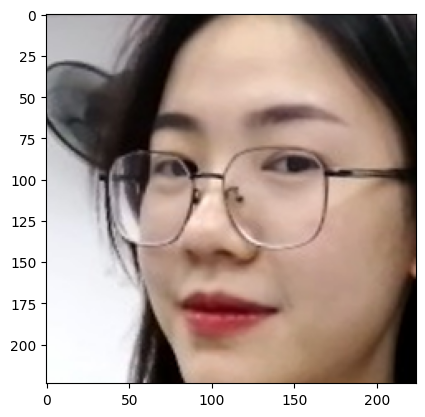

In [85]:
query_image_path = './tests/xofb230517_153544.png'  
query_image = cv2.imread(query_image_path)
query_rgb_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_rgb_image)
plt.show()

In [86]:
query_rgb_image = query_rgb_image[None,:,:]
query_rgb_image.shape

(1, 224, 224, 3)

In [87]:
embedder = ArcFaceONNX(model_file="./models_arcface/glint360K_r18/r18_glint360k_112x112.onnx")
embedded_vecs = embedder.forward(query_rgb_image)
embedded_vecs = embedded_vecs.tolist()

In [100]:
#using 
search_params = {
    
    "params": {
        "nprobe": 16, # int. 1~nlist(cpu), 1~min[2048, nlist](gpu)
    }, 
}
results = collection.search(embedded_vecs, "Embeddings", search_params, limit=1, output_fields=["ID","Name_VN"])
for i, result in enumerate(results):
    print("\nSearch result for {}th vector: ".format(i))
    for j, res in enumerate(result):
        print("Top {}: {}".format(j, res))


Search result for 0th vector: 
Top 0: id: NS0209, distance: 276.247802734375, entity: {'ID': 'NS0209', 'Name_VN': 'Vu Phuong Hoa'}


In [92]:
## using annoy
top_k = 10
results = collection.search(embedded_vecs, anns_field="Embeddings",param={
                "search_k": -1    # int. {-1} U [top_k, n*n_trees], n represents vectors count.
              }, limit=top_k,output_fields=["ID","Name_VN"]) # show results
for i, result in enumerate(results):
    print("\nSearch result for {}th vector: ".format(i))
    for j, res in enumerate(result):
        print("Top {}: {}".format(j, res))


Search result for 0th vector: 
Top 0: id: NS0209, distance: 276.247802734375, entity: {'ID': 'NS0209', 'Name_VN': 'Vu Phuong Hoa'}
Top 1: id: NS0024, distance: 561.4186401367188, entity: {'ID': 'NS0024', 'Name_VN': 'NGUYEN HOAI NAM'}
